In [1]:
#!pip install tensorflow==2.7.0
#!pip install scikeras

# Subclassing for GCCE

In [2]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import matplotlib.pyplot as plt
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow_probability as tfp
from tensorflow.keras import regularizers
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import train_test_split
from keras.models import Sequential

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras.layers import BatchNormalization
from tensorflow.keras import regularizers

tf.keras.backend.clear_session()
#tf.random.set_seed(42)
import types
import tempfile
class Keras_MA_CNN(): #transformer no va
 #Constructor __init__. Special method: identified by a double underscore at either side of their name
 #work in the background
 # initialize data members to the object. lets the class initialize the object’s attributes and serves no other purpose.
    def __init__(self,epochs=70,batch_size=30,R=5, K=2, dropout=0.5, learning_rate=1e-3,optimizer='Adam', 
                  l1_param=0, validation_split=0.3, verbose=1, q = 0.1):
        self.epochs=epochs
        self.dropout=dropout
        self.batch_size = batch_size
        self.learning_rate=learning_rate 
        self.l1_param=l1_param 
        self.l2_param=l1_param
        self.validation_split = validation_split
        self.verbose = verbose
        self.optimizer = optimizer
        self.R=R
        self.K=K
        self.q = q

    
 
    def GCCE_MA_loss(self, y_true, y_pred):
        # print(y_true,y_pred)
       # q = 0.1
        pred = y_pred[:, self.R:]
        pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1)
        ann_ = y_pred[:, :self.R]
        # ann_ = tf.clip_by_value(ann_, clip_value_min=1e-9, clip_value_max=1-1e-9)
        Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
        Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)

        p_gcce = Y_true*(1 - Y_hat**self.q)/self.q
        temp1 = ann_*tf.math.reduce_sum(p_gcce, axis=1)

        # p_logreg = tf.math.reduce_prod(tf.math.pow(Y_hat, Y_true), axis=1)
        # temp1 = ann_*tf.math.log(p_logreg)  
        # temp2 = (1 - ann_)*tf.math.log(1/K)*tf.reduce_sum(Y_true,axis=1)
        # aux = tf.repeat(tf.reduce_sum(pred*tf.math.log(pred),axis=1,keepdims=True), R, axis = 1)
        # tf.print(tf.shape(aux))
        # print(tf.shape(aux))
        # temp2 = (1 - ann_)*aux*tf.reduce_sum(Y_true,axis=1)
        # temp2 = (tf.ones(tf.shape(ann_)) - ann_)*tf.math.log(1/K)
        # print(tf.reduce_mean(Y_true,axis=1).numpy())
        # Y_true_1 = tf.clip_by_value(Y_true, clip_value_min=1e-9, clip_value_max=1)
        # p_logreg_inv = tf.math.reduce_prod(tf.math.pow(Y_true_1, Y_hat), axis=1)
        # temp2 = (1 - ann_)*tf.math.log(p_logreg_inv) 
        temp2 = (1 - ann_)*(1-(1/self.K)**self.q)/self.q*tf.reduce_sum(Y_true,axis=1)
        return tf.math.reduce_sum((temp1 + temp2))

 
    def PRI_MA_loss(self, y_true, y_pred): #,  -> PRI
        #Input ytrue: samples (N) x  annotators (R) 
        #Input ypred: samples (N) x  annotators+classes (R+K) 
        #PRI MA
        cce_M = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=-1)
        cce_C = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=1)

      

        #N = tf.cast(y_true.shape[0],dtype=tf.int32)
        N = tf.shape(y_true)[0]
        #Ground truth estimation samples (N) x  Classes(K)
        y_pred_tf = y_pred[:,self.R:] 
        # Annotators reliability prediction: samples (N) x  annotators (R)
        lambda_R_tf = y_pred[:,:self.R] #tf.ones(shape=(N,R)) 
        #Y_true 1 K: samples (N) x  Classes(1-K), annotators (R)
        Y_true_1K = tf.one_hot(tf.cast(y_true,dtype=tf.int32),depth=self.K,axis=1)  
        #Y_pred 1 - K: samples (N) x  Classes(1-K), annotators (R)
        Y_hat = tf.repeat(tf.expand_dims(y_pred_tf,-1), self.R, axis = -1) 
        #marginal entropy
        #cce along the K classes -> ypred_tf
        Hm_ = cce_M(y_pred_tf,y_pred_tf)
        #cross entropy
        #cce along the K classes -> Y_hat
        Hc_ = cce_C(Y_true_1K,Y_hat)
        #PRI MA computation
        LH = tf.linalg.matmul(lambda_R_tf,Hc_,transpose_a=True) # \Lambda^\top H_c
        temp1 = tf.linalg.trace(LH) #trace(LH)
        Hm1L = tf.linalg.matmul(tf.ones(shape=(N,self.R))-lambda_R_tf,tf.ones(shape=(self.R,1)))# 1_N 1_R^\top - Lambda
        Hm_t = tf.reshape(Hm_,shape=(N,1))
        temp2 = tf.squeeze(tf.linalg.matmul(Hm_t,Hm1L,transpose_a=True)) # Hm^\top Hm1L
        loss_c = temp1+ temp2 #return loss

        return loss_c

 
    def fit(self, X, Y):
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        P = X.shape[1]
        if self.optimizer == "Adam":
            opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate, clipnorm=1.0)
        elif self.optimizer == "SGD":
            opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate, clipnorm=1.0)
        else:
            opt=self.optimizer

            

        self.model = Sequential()

        self.model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
        self.model.add(BatchNormalization(axis=-1))
        self.model.add(Activation('relu'))
        self.model.add(Conv2D(32, (3, 3)))
        self.model.add(BatchNormalization(axis=-1))
        self.model.add(Activation('relu'))
        self.model.add(MaxPooling2D(pool_size=(2,2)))

        self.model.add(Conv2D(64,(3, 3)))
        self.model.add(BatchNormalization(axis=-1))
        self.model.add(Activation('relu'))
        self.model.add(Conv2D(64, (3, 3)))
        self.model.add(BatchNormalization(axis=-1))
        self.model.add(Activation('relu'))
        self.model.add(MaxPooling2D(pool_size=(2,2)))

        self.model.add(Flatten())

        # Fully connected layer
        self.model.add(Dense(512))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(10))

        self.model.add(Activation('softmax'))



        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm = 1.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
     
#         #capa de entrada
#         input_l = tf.keras.layers.Input(shape=(X_train.shape[1]), name='entrada')
#         #capas densas
#         h1 = tf.keras.layers.Dense(200,activation='selu',name='h1',
#                               kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(input_l)#argumento de entrada
#         h2 = tf.keras.layers.Dense(50,activation='selu',name='h2',
#                               kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(h1)
#         dout = tf.keras.layers.Dropout(rate=self.dropout)(h2)
#        #capa de salida
#         output = tf.keras.layers.Dense(self.K,activation="softmax",name='output',
#                                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(dout)
#         self.model = tf.keras.Model(inputs= input_l,outputs=output)
#         self.model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=opt,metrics=["accuracy"])
         
            
 
        self.history = self.model.fit(X, Y, epochs=self.epochs, validation_split=self.validation_split,   #
                                      batch_size=self.batch_size,verbose=self.verbose)
 
        return self
 
  
    
    def predict(self, X, *_):
       #input X numpy array first dimension samples (N)x features (P)
      return  self.model.predict(X) 
 
 

    def fit_predict(self,X,y):
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        self.fit(X,y)
        return self.predict(X)
  
     #graphics
    def plot_history(self):
        pd.DataFrame(self.history.history).plot(figsize=(8, 5))
        plt.grid(True)
        #plt.gca().set_ylim(0, 1)
        #save_fig("keras_learning_curves_plot")
        plt.show()
        return
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)

        return self
    
    
    
    def get_params(self, deep=True):
        return { 'l1_param':self.l1_param, 'dropout':self.dropout, 'optimizer':self.optimizer,
                'learning_rate':self.learning_rate, 'batch_size':self.batch_size,
                'epochs':self.epochs, 'verbose':self.verbose, 'validation_split':self.validation_split,
                'R':self.R, 'K':self.K, 'q':self.q
                }

  
        return self


# Load Data

In [3]:
#load data
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf #importar tensorflow
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np

database = 'Fashion_Mnist'
 

In [4]:
mnist = tf.keras.datasets.mnist
(x_train, Y_true_train), (x_test, Y_true_test) = mnist.load_data()

11501568/11490434 [==============================] - 1s 0us/step


In [5]:
input_shape = (28, 28, 1)

X_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
X_train=X_train / 255.0
X_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
X_test=X_test/255.0

5


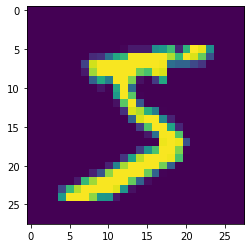

In [6]:
plt.imshow(X_train[0])
print(Y_true_train[100])

# Labels Generation 


In [7]:
import random
import warnings
import numpy as np
#import climin
from functools import partial
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

#Defining the Sigmoid function and Softmax function
def Sigmoid(f_r):
    lam_r = 1/(1 + np.exp(-f_r))
    return lam_r

def MAjVot(Y, K):
    N,R = Y.shape
    Yhat = np.zeros((N,1))
    for n in range(N):
        votes = np.zeros((K,1))
        for r in range(R):
            for k in range(K):
                if Y[n,r] == k+1:
                    votes[k] = votes[k]+1
        Yhat[n] = np.argmax(votes) + 1
    return Yhat


def  MA_Clas_Gen(Xtrain,ytrain,R,NrP):

    N = len(ytrain)
    K = len(np.unique(ytrain))
    Kn = np.unique(ytrain)
    aux = 0
    A = np.zeros((K,1))
    for k in Kn:
        A[aux] = (ytrain == k).sum()
        aux = aux + 1
    per = np.min(A)
    if N < 25000:
        Xtrain = TSNE(n_components=1,perplexity=per/2).fit_transform(Xtrain)
    else:
        Xtrain = np.sum(Xtrain,1)
    # Xtrain = Xtrain-Xtrain.min()
    # Xtrain = Xtrain/Xtrain.max()
    #ytrain = y
    # scaler = StandardScaler()
    # scalerY = scaler.fit(y)
    # ytrain = scaler.fit_transform(y)

    
    #miny = y.min()
    #ytrain = y-miny
    #maxy = ytrain.max()
    #ytrain = ytrain/maxy
  
    # Xtrain = np.sum(Xtrain, axis=1)
    Xtrain = Xtrain - Xtrain.min()
    #print(Xtrain.min(), Xtrain.max())
    Xtrain = Xtrain/Xtrain.max()
    Xtrain = Xtrain.reshape((N,1))
    yprueba = np.ones((N,1))
    
    
    u_q = np.empty((Xtrain.shape[0],3))
    u_q[:,0,None] = 4.5*np.cos(2*np.pi*Xtrain + 1.5*np.pi) - \
                               3*np.sin(4.3*np.pi*Xtrain + 0.3*np.pi)
                    
    u_q[:,1,None] = 4.5*np.cos(1.5*np.pi*Xtrain + 0.5*np.pi) + \
                       5*np.sin(3*np.pi*Xtrain + 1.5*np.pi)
    
    u_q[:,2,None] = 1
    
    W = []
    # q=1
    Wq1 = np.array(([[0.4],[0.7],[-0.5],[0],[-0.7]]))
    W.append(Wq1)
    # q=2
    Wq2 = np.array(([[0.4],[-1.0],[-0.1],[-0.8],[1.0]]))
    W.append(Wq2)
    Wq3 = np.array(([[3.1],[-1.8],[-0.6],[-1.2],[1.0]]))
    W.append(Wq3)

    
    F_r = []
    Lam_r = []
    for r in range(R):
        f_r = np.zeros((Xtrain.shape[0], 1))
        # rho_r = np.zeros((Xtrain.shape[0], 1))
        for q in range(3):
            f_r += W[q][r].T*u_q[:,q,None]
        F_r.append(f_r)
        lam_r = Sigmoid(f_r)
        lam_r[lam_r>0.5] = 1
        lam_r[lam_r<=0.5] = 0
        Lam_r.append(lam_r)
    plt.plot(Xtrain,Lam_r[2],'rx')
    plt.show()
    seed = 0
    np.random.seed(seed)
    Ytrain = np.ones((N, R))
    for r in range(R):
        aux = ytrain.copy()
        for n in range(N):
            if Lam_r[r][n] == 0:
                labels = np.arange(1, K+1)
                a = np.where(labels==ytrain[n])
                labels = np.delete(labels, a)
                idxlabels = np.random.permutation(K-1)
                aux[n] = labels[idxlabels[0]]         
        Ytrain[:,r] = aux.flatten()
        
   # Ytrain = (Ytrain*maxy) + miny
        
    iAnn = np.zeros((N, R), dtype=int) # this indicates if the annotator r labels the nth sample.
    Nr = np.ones((R), dtype=int)*int(np.floor(N*NrP))  
    for r in range(R):
        if r < R-1:
            indexR = np.random.permutation(range(N))[:Nr[r]]
            iAnn[indexR,r] = 1
        else:
            iSimm = np.sum(iAnn, axis=1)
            idxZero = np.asarray([i for (i, val) in enumerate(iSimm) if val == 0])
            Nzeros = idxZero.shape[0]
            idx2Choose = np.arange(N)
            if Nzeros == 0:
                indexR = np.random.permutation(range(N))[:Nr[r]]
                iAnn[indexR,r] = 1
            else:
                idx2Choose = np.delete(idx2Choose, idxZero)
                N2chose = idx2Choose.shape[0]
                idxNoZero = np.random.permutation(N2chose)[:(Nr[r] - Nzeros)]
                idxTot = np.concatenate((idxZero, idx2Choose[idxNoZero]))
                iAnn[idxTot,r] = 1
    
    # Now, we verify that all the samples were labeled at least once
    Nr = (np.sum(iAnn,0))
    iSimm = np.sum(iAnn, axis=1)
    if np.asarray([i for (i, val) in enumerate(iSimm) if val == 0]).sum() == 0:
        ValueError("all the samples must be labeled at least once")

    # Finally, if iAnn=0 we assign a reference value to indicate a missing value
    Vref = -1e-20
    for r in range(R):
        Ytrain[iAnn[:,r] == 0, r] = Vref 

    return Ytrain, iAnn, Lam_r


def CrossVal(X, pp, Nk):
    N = X.shape[0]
    Ntr = int(N*pp)
    Nte = N - Ntr
    idxtr = np.zeros((Ntr,Nk))
    idxte = np.zeros((Nte,Nk))
    
    for i in range(Nk):
        index = np.random.permutation(range(N))
        idxtr[:,i] = index[:Ntr]
        idxte[:,i] = index[Ntr:]
        
    return idxtr, idxte
    
    
        


# Testing the Class 


iteration: 0


2023-02-04 00:05:48.232790: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 00:05:48.476907: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 00:05:48.477760: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 00:05:48.480198: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

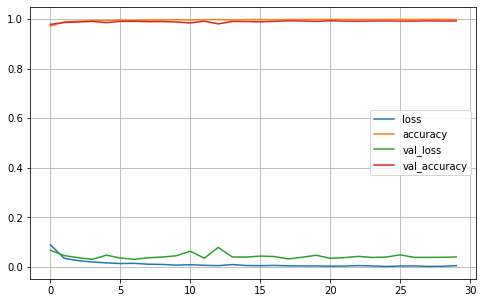

Validation ACC: 0.9936
Validation Balanced_ACC: 0.9928
Validation MI: 2.2562
Validation Normalized MI: 0.9806
Validation Adjusted MI: 0.9805
Validation aUc: 0.9993
iteration: 1


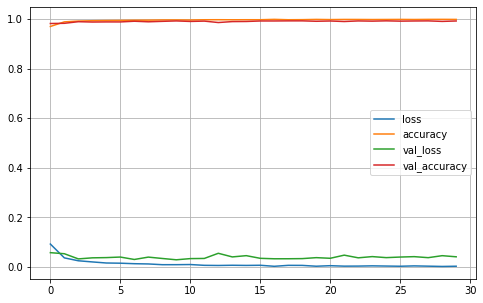

Validation ACC: 0.9928
Validation Balanced_ACC: 0.9920
Validation MI: 2.2503
Validation Normalized MI: 0.9780
Validation Adjusted MI: 0.9780
Validation aUc: 0.9980
iteration: 2


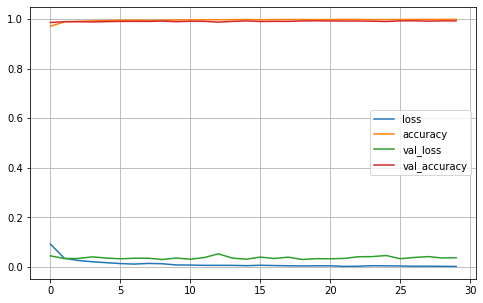

Validation ACC: 0.9936
Validation Balanced_ACC: 0.9928
Validation MI: 2.2557
Validation Normalized MI: 0.9804
Validation Adjusted MI: 0.9804
Validation aUc: 0.9972
iteration: 3


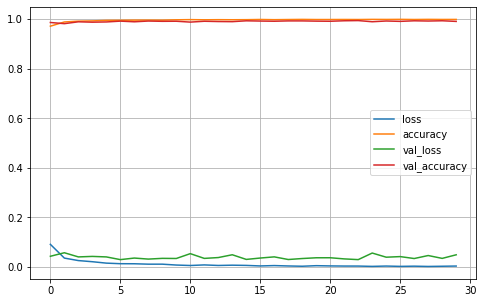

Validation ACC: 0.9932
Validation Balanced_ACC: 0.9923
Validation MI: 2.2535
Validation Normalized MI: 0.9794
Validation Adjusted MI: 0.9794
Validation aUc: 0.9979
iteration: 4


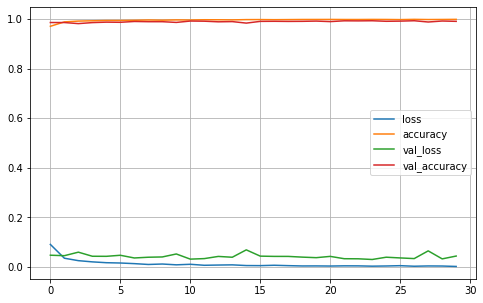

Validation ACC: 0.9933
Validation Balanced_ACC: 0.9924
Validation MI: 2.2539
Validation Normalized MI: 0.9796
Validation Adjusted MI: 0.9796
Validation aUc: 0.9980
iteration: 5


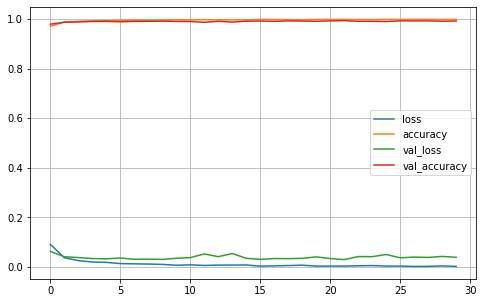

Validation ACC: 0.9944
Validation Balanced_ACC: 0.9937
Validation MI: 2.2609
Validation Normalized MI: 0.9826
Validation Adjusted MI: 0.9826
Validation aUc: 0.9980
iteration: 6


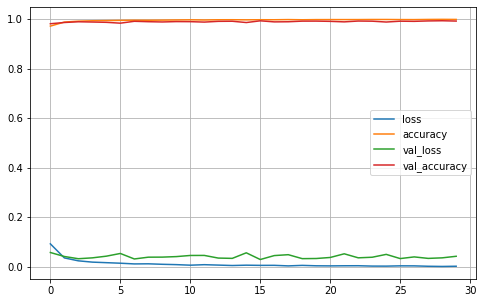

Validation ACC: 0.9921
Validation Balanced_ACC: 0.9911
Validation MI: 2.2476
Validation Normalized MI: 0.9769
Validation Adjusted MI: 0.9769
Validation aUc: 0.9972
iteration: 7


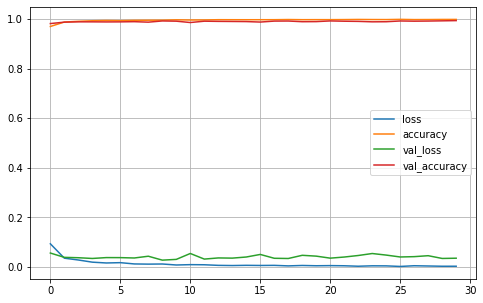

Validation ACC: 0.9931
Validation Balanced_ACC: 0.9923
Validation MI: 2.2528
Validation Normalized MI: 0.9791
Validation Adjusted MI: 0.9791
Validation aUc: 0.9973
iteration: 8


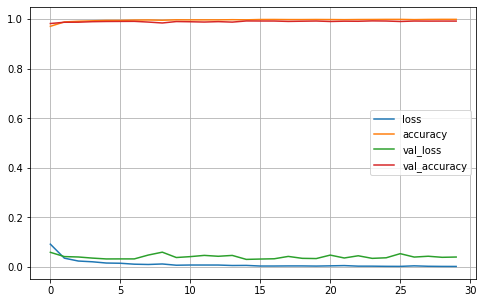

Validation ACC: 0.9928
Validation Balanced_ACC: 0.9919
Validation MI: 2.2534
Validation Normalized MI: 0.9794
Validation Adjusted MI: 0.9793
Validation aUc: 0.9986
iteration: 9


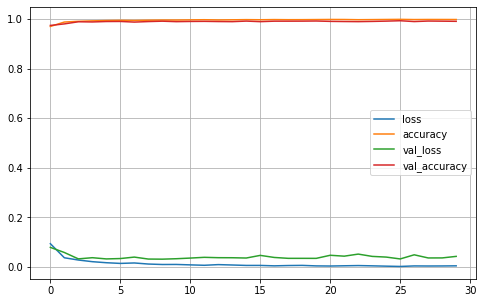

Validation ACC: 0.9927
Validation Balanced_ACC: 0.9918
Validation MI: 2.2514
Validation Normalized MI: 0.9785
Validation Adjusted MI: 0.9785
Validation aUc: 0.9996


In [8]:
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
l1 =  0.0001
NUM_RUNS =10
ACC = np.zeros(NUM_RUNS)
AUC = np.zeros(NUM_RUNS)
MI = np.zeros(NUM_RUNS)
NMI = np.zeros(NUM_RUNS)
AMI = np.zeros(NUM_RUNS)
BACC = np.zeros(NUM_RUNS)
for i in range(NUM_RUNS): #10
    print("iteration: " + str(i))
   
    MA = Keras_MA_CNN(epochs=30,batch_size=64,R=5, K=len(np.unique(Y_true_train)), dropout=0.5, learning_rate=0.01,optimizer='Adam', 
                l1_param=l1,  validation_split=0.30, verbose=0, q=0.1)
    
    MA.fit(X_train, Y_true_train)
    MA.plot_history()
  
    #Accuracy
    pred_2 = MA.predict(X_test)
 
    report = classification_report( pred_2.argmax(axis=1),Y_true_test.ravel(),output_dict=True)
    ACC[i] = report['accuracy']
    print("Validation ACC: %.4f" % (float(ACC[i])))


    # balanced. Accurcy
    BACC[i] = balanced_accuracy_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze(), adjusted=True)
    print("Validation Balanced_ACC: %.4f" % (float(BACC[i])))

    #MI
    
    MI[i] = mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
    print("Validation MI: %.4f" % (float(MI[i]),))
    NMI[i] = normalized_mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
    print("Validation Normalized MI: %.4f" % (float(NMI[i]),))
    AMI[i]= adjusted_mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
    print("Validation Adjusted MI: %.4f" % (float(AMI[i]),))


    #AUC
    val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)  
   # val_logits =MA.predict(X_test) # model(X_test, training=False)
    # tf.print(y_batch_val)
    val_AUC_metric.update_state(Y_true_test, pred_2.argmax(axis=1).astype('float'))

    val_AUC = val_AUC_metric.result()
    val_AUC_metric.reset_states()
    val_AUC = val_AUC.numpy()
    print("Validation aUc: %.4f" % (float(val_AUC),))
    AUC[i] = val_AUC
    

In [9]:
# l1 =1
# MA = Keras_MA_CNN(epochs=30,batch_size=64,R=5, K=len(np.unique(Y_true_train)), dropout=0.5, learning_rate=0.01,optimizer='Adam', 
#                 l1_param=l1,  validation_split=0.30, verbose=0, q=0.1)

# MA.fit(X_train, Y_true_train)
# MA.plot_history()
# output_MA_ = MA.predict(X_test)


In [10]:
print('Average Accuracy: ', np.round( ACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( ACC),4)*100)
print('==============================================')
print('Average AUC: ', np.round( AUC.mean(),4)*100) 
print('Average AUC std: ',np.round(np.std( AUC),4)*100)
print('==============================================')
print('Average Balanced Accuracy: ', np.round( BACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( BACC),4)*100)
print('==============================================')
print('Average MI: ', np.round( MI.mean(),4)*100) 
print('Average std: ',np.round(np.std(MI),4)*100)
print('==============================================')
print('Average Normalized MI: ', np.round( NMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(NMI),4)*100)
print('==============================================')
print('Average Ajdusted MI: ', np.round( AMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(AMI),4)*100)

Average Accuracy:  99.32
Average std:  0.06
Average AUC:  99.81
Average AUC std:  0.08
Average Balanced Accuracy:  99.22999999999999
Average std:  0.06999999999999999
Average MI:  225.36
Average std:  0.33999999999999997
Average Normalized MI:  97.95
Average std:  0.15
Average Ajdusted MI:  97.94
Average std:  0.15


# Gridsearch 

In [11]:
import numpy as np 
from sklearn.model_selection import  StratifiedShuffleSplit, ShuffleSplit
#from scikeras.wrappers import KerasClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import make_scorer
import joblib
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

#https://www.adriangb.com/scikeras/stable/notebooks/DataTransformers.html?highlight=data+processing#3.2-Define-output-data-transformer

filename = '/kaggle/working/' + database +'_models_GCCE'
filename_labels = '/kaggle/working/' + database +'_GCCE_labels'
 

best_parameter = []
cvresults = []
classification_report_r= []
models = []
labels_pred2=[]
labels_Y_true=[]
NUM_RUNS =5

for i in range(NUM_RUNS): #10
    print("iteration: " + str(i))
    #Ns = 1
    cv = 10 #cantidad de iteraciones
#     ss = ShuffleSplit(n_splits=cv, test_size=0.3,random_state =123)
#     for train_index, test_index in ss.split(X):
#        # print(test_index)
#         X_train, X_test,Y_train,Y_test = X[train_index,:], X[test_index,:] ,Ytr_mv[train_index,:], Ytr_mv[test_index,:]
#         Y_true_train, Y_true_test = t[train_index].reshape(-1,1), t[test_index].reshape(-1,1)
#         for i in range(Y.shape[1]):
#             #print('annotator',i+1)

#             unique, counts = np.unique(Y_train[:,i], return_counts=True)
#             plt.figure()
#             plt.bar(unique, counts)
#             unique, counts = np.unique(Y_test[:,i], return_counts=True)
#             plt.bar(unique, counts)

#             plt.title('Class Frequency for Y_true')
#             plt.xlabel('Class')
#             plt.ylabel('Frequency')
#       
    MA = Keras_MA_CNN(validation_split= 0.3, R= Y_true_test.shape[1], K=len(np.unique(Y_true_test)))

    
    
    scce = tf.keras.losses.SparseCategoricalCrossentropy()

    #================================ GridSearch =============================================
    my_func = make_scorer(lambda y,y_pred: scce(y,y_pred).numpy(),greater_is_better=False)
    #================== pipeline ===================================== 
        #se crean listas de steps (pipelines)
    steps=[('nor', MinMaxScaler()),
            ('cla', Keras_MA_CNN(validation_split= 0.3,R= Y_true_test.shape[1], K=len(np.unique(Y_true_test)), verbose=0))] #Pipeline1
        
    
    parameters = [{              
                  'cla__dropout': [0.25, 0.5, 0.75, 0.2],#Pipeline1 - hyperparametros
                  #'cla__learning_rate': [1e-4, 1e-3, 1e-2, 1e-1],
                  #'cla__l1_param': [1e-4, 1e-3, 1e-2, 1e-1],
                  'cla__batch_size': [32, 64, 128, 256], 
                  #'cla__q': [0.01]
        
                 #'cla__loss': [GCCE_MA_loss]
                      
                  }]

    label_models = ['model']
    
    
  
    #param_grid = dict(model__dropout_rate=dropout_rate)
    grid = RandomizedSearchCV( Pipeline(steps), parameters,  n_jobs=-1, cv=ss, scoring= my_func, #-1
                        error_score="raise",refit= True,verbose=0, n_iter=10)
    grid_result = grid.fit(X_train, Y_true_train)



    best_parameter += [grid_result.best_params_ ]   
    cvresults += [grid_result.cv_results_]
    pred_2 = grid.predict(X_test)
    labels_pred2 += [pred_2]
    labels_Y_true +=[Y_true_test.ravel()]
    classification_report_r += [classification_report( pred_2.argmax(axis=1),Y_true_test.ravel(),output_dict=True)]
    #accuracy_score(Y_true_test,grid.predict(X_test))]
    #models += [grid] #guardar modelos
joblib.dump([best_parameter,cvresults,classification_report_r],filename+".pkl")
joblib.dump([labels_pred2,labels_Y_true],filename_labels +".pkl")

iteration: 0


IndexError: tuple index out of range

# computing precision, recall, f1-score  mean values for every class

In [ ]:
val_acc_GCCE  = np.zeros(NUM_RUNS)
val_Precision =  np.zeros((len(classification_report_r),len(classification_report_r[0].keys())-3))
val_recall =  np.zeros((len(classification_report_r),len(classification_report_r[0].keys())-3))
val_f1_score =  np.zeros((len(classification_report_r),len(classification_report_r[0].keys())-3))
for i in range(len(classification_report_r)):
    
    for j in range(len(classification_report_r[0].keys())-3):
        val_Precision[i][j] = classification_report_r[i][str(j)]['precision']
        val_recall[i][j] = classification_report_r[i][str(j)]['recall']
        val_f1_score[i][j] = classification_report_r[i][str(j)]['f1-score']
        
     
    val_acc_GCCE[i] = classification_report_r[i]['accuracy']
#print(classification_report_r[0]['precision'])'recall'
print('Average precision classes: ',  np.mean(val_Precision, axis=0))
print('Average Recall classes: ', np.mean(val_recall, axis=0))
print('Average f1_score classes: ', np.mean(val_f1_score, axis=0)) 


In [ ]:
val_acc_GCCE

In [ ]:
 
print('Average Accuracy: ', np.round(val_acc_GCCE.mean(),4)*100) 
print('Average std: ',np.round(np.std(val_acc_GCCE),4)*100)

In [ ]:
best_batch_list = []
best_dropout_list = []
best_l1_coef_list = []
best_l1_coef_list = []
best_learning_rate_list = []
best_q = []
for i in range(len(best_parameter)):
    best_batch_list += [best_parameter[i]['cla__batch_size']]
    best_dropout_list += [best_parameter[i]['cla__dropout']]
    best_l1_coef_list += [best_parameter[i]['cla__l1_param']]
    best_learning_rate_list += [best_parameter[i]['cla__learning_rate']]
    best_q += [best_parameter[i]['cla__q']]
   # print(best_parameter[i]['cla__batch_size'])
   # print(best_parameter[i]['cla__batch_size'])

 

In [ ]:
best_q

# Mode  across gridsearch N iteratios parameters

In [ ]:
import numpy as np
from scipy import stats
  
batch_size_mode = np.take(stats.mode(best_batch_list)[0],0)
dropout_mode =  np.take(stats.mode(best_dropout_list ) [0],0)
l1_coef_mode =   np.take(stats.mode(best_l1_coef_list )[0],0)
learning_rate_mode =  np.take(stats.mode(best_learning_rate_list )[0],0)
q_param =  np.take(stats.mode(best_q )[0],0)
print('batch_size_mode :',batch_size_mode)
print('dropout_mode :',dropout_mode )
print('l1_coef_mode :', l1_coef_mode)
print('learning_rate_mode: ',learning_rate_mode)
print('q_parameter: ',q_param)